In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
import qutip
from scipy.linalg import sqrtm

from povm_clf import *

---
# 1. Funtions in povm_clf

## 1-1. State Preparation

### Mixed states

In [2]:
test = SingleQubitPOVM(bloch_vec=[0.7,0,0])
@qml.qnode(qml.device('default.qubit', wires=2))
def circ_test():
    test.state_prepared_on_circuit(wires=[0,1]) #요거 그림 그려보기!
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.7, 0, 0]
Output Bloch vector =  [0.69969391 0.00562435 0.00250519]


### Circuit Diagram

In [3]:
diagram = qml.draw(circ_test)
print(diagram())

 0: ──Rot(-0.386, 8.05, 3.08)──╭C──Rot(-3.5, 9.74, 5.89)─────╭┤ ⟨Z ⊗ Z⟩ 
 1: ──Rot(-2.78, 3.92, 0.222)──╰X──Rot(1.76, -0.712, -9.72)──╰┤ ⟨Z ⊗ Z⟩ 



---
# 2. Pure-state Classifier

##  Two-element POVM

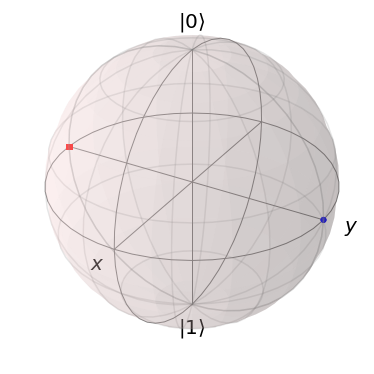

In [7]:
n = 2
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1]
bloch_vecs = [[0,1,0], [0,-1,0]]
a_priori_probs = [1/n] * n


# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [9]:
classifier = POVM_clf(2, wires, dev, a_priori_probs, bloch_vecs)
Helstrom_bound = classifier.spectral_decomp()
print("Helstrom bound:", Helstrom_bound)

# Simulation
steps=400
cost_list = classifier.run_opt(steps)

Helstrom bound: 0.0
Cost(init_params)    :  0.4999924
Cost after step    20:  0.4999881
Cost after step    40:  0.4999825
Cost after step    60:  0.4999746
Cost after step    80:  0.4999630
Cost after step   100:  0.4999447
Cost after step   120:  0.4999144
Cost after step   140:  0.4998599
Cost after step   160:  0.4997508
Cost after step   180:  0.4994980
Cost after step   200:  0.4987660
Cost after step   220:  0.4956657
Cost after step   240:  0.4679395
Cost after step   260:  0.1067236
Cost after step   280:  0.0015750
Cost after step   300:  0.0000233


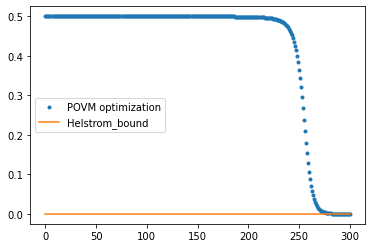

In [10]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound]*(steps+1), '-', label="Helstrom_bound")
plt.legend()
plt.show()

In [11]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.9999767345034047
performed PGM: 2.220446049250313e-16


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000+0.5000j,,0.5000+0.0000j,0.0000-0.5000j,
,0.0000+0.5000j,0.5000+0.0000j,0.0000-0.5000j,0.5000+0.0000j,0.0000,0.0000+0.5000j,0.5000+0.0000j,1.0000
i=1,0.5000+0.0000j,0.0000+0.5000j,0.5000+0.0000j,-0.0000-0.5000j,,0.5000+0.0000j,0.0000+0.5000j,
,0.0000-0.5000j,0.5000+0.0000j,-0.0000+0.5000j,0.5000+0.0000j,0.0000,0.0000-0.5000j,0.5000+0.0000j,1.0000


## Three-element POVM

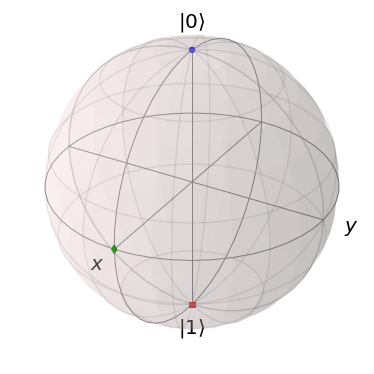

In [12]:
n = 3
dev = [qml.device('default.qubit', wires=n)] * n
wires = [0, 1, 2]

"""
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
"""

state_vecs = [[1, 0], [0, 1], [1/np.sqrt(2), 1/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
a_priori_probs = [1/n] * n


# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [15]:
classifier = POVM_clf(n, wires, dev, a_priori_probs, bloch_vecs)
pgm, cost_pgm = classifier.pgm()
print("Cost fn based on PGM:", cost_pgm)

# Simulation
steps = 400
cost_list = classifier.run_opt(steps)

Cost fn based on PGM: 0.34763107293781825
Cost(init_params)    :  0.6870286
Cost after step    20:  0.5332506
Cost after step    40:  0.4288344
Cost after step    60:  0.3918097
Cost after step    80:  0.3705985
Cost after step   100:  0.3549658
Cost after step   120:  0.3448938
Cost after step   140:  0.3392197
Cost after step   160:  0.3362603
Cost after step   180:  0.3347735
Cost after step   200:  0.3340391
Cost after step   220:  0.3336789
Cost after step   240:  0.3335026
Cost after step   260:  0.3334164
Cost after step   280:  0.3333742
Cost after step   300:  0.3333535
Cost after step   320:  0.3333433
Cost after step   340:  0.3333383
Cost after step   360:  0.3333358
Cost after step   380:  0.3333346
Cost after step   400:  0.3333340


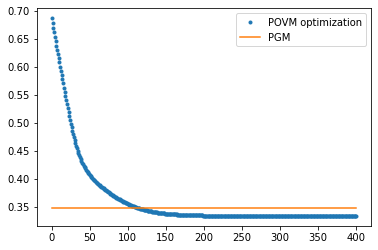

In [16]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM optimization')
pgm, cost_pgm = classifier.pgm()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [17]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("Minimum-Error Discrimination")
print("performed optimal POVM:", med_povm)
print("performed PGM:", med_pgm)

classifier.res_table()

Minimum-Error Discrimination
performed optimal POVM: 0.3333339508483174
performed PGM: 0.34763107293781825


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,1.0000+0.0000j,0.0000+0.0000j,1.0000+0.0000j,-0.0000-0.0000j,,0.7286+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,0.0000+0.0000j,-0.0000+0.0000j,0.0000+0.0000j,1.0000,-0.1250+0.0000j,0.0214+0.0000j,0.7286
i=1,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,,0.0214+0.0000j,-0.1250+0.0000j,
,0.0000+0.0000j,1.0000+0.0000j,0.0000-0.0000j,1.0000+0.0000j,1.0000,-0.1250+0.0000j,0.7286+0.0000j,0.7286
i=2,0.5000+0.0000j,0.5000+0.0000j,0.0000+0.0000j,0.0000+0.0000j,,0.2500+0.0000j,0.2500+0.0000j,
,0.5000+0.0000j,0.5000+0.0000j,0.0000-0.0000j,0.0000+0.0000j,0.0000,0.2500+0.0000j,0.2500+0.0000j,0.5000


---
# 3. Mixed-state Classifier

## Two-element POVM

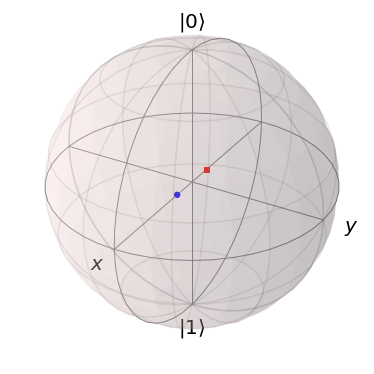

In [18]:
n = 2
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2]
bloch_vecs = [[0.2,0,0], [0,0,0.2]]
a_priori_probs = [1/n] * n


# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [19]:
classifier = POVM_clf(2, wires, devs, a_priori_probs, bloch_vecs)
Helstrom_bound_exact = classifier.spectral_decomp()
Helstrom_bound_noisy = classifier.spectral_decomp(types='noisy')

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.2, 0, 0]
Output Bloch vector =  [0.19820978 0.0006546  0.00154326]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.2, 0, 0]
Output Bloch vector =  [-0.20001478 -0.00167471 -0.00026973]


In [20]:
steps=400
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.4999858
Cost after step    20:  0.4999445
Cost after step    40:  0.4998611
Cost after step    60:  0.4996722
Cost after step    80:  0.4992358
Cost after step   100:  0.4982288
Cost after step   120:  0.4959360
Cost after step   140:  0.4908836
Cost after step   160:  0.4805763
Cost after step   180:  0.4628264
Cost after step   200:  0.4404106
Cost after step   220:  0.4215827
Cost after step   240:  0.4104329
Cost after step   260:  0.4049717
Cost after step   280:  0.4024733
Cost after step   300:  0.4013506
Cost after step   320:  0.4008480
Cost after step   340:  0.4006231
Cost after step   360:  0.4005225
Cost after step   380:  0.4004775
Cost after step   400:  0.4004574


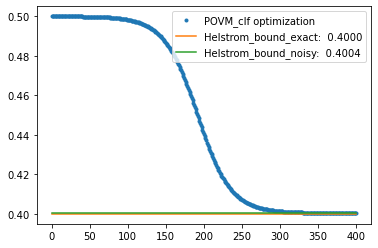

In [21]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
plt.plot(list(range(steps+1)), [Helstrom_bound_exact]*(steps+1), '-', label="Helstrom_bound_exact: {: .4f}".format(Helstrom_bound_exact))
plt.plot(list(range(steps+1)), [Helstrom_bound_noisy]*(steps+1), '-', label="Helstrom_bound_noisy: {: .4f}".format(Helstrom_bound_noisy))
plt.legend()
plt.show()

In [22]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

classifier.res_table()

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.400019001616845
by performing PGM: 0.4800000000000001


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,0.1000+0.0000j,0.5022+0.0000j,0.4999-0.0029j,,0.5000+0.0000j,0.1000+0.0000j,
,0.1000+0.0000j,0.5000+0.0000j,0.4999+0.0029j,0.4979+0.0000j,0.6001,0.1000+0.0000j,0.5000+0.0000j,0.5200
i=1,0.5000+0.0000j,-0.1000+0.0000j,0.4978+0.0000j,-0.4999+0.0029j,,0.5000+0.0000j,-0.1000+0.0000j,
,-0.1000+0.0000j,0.5000+0.0000j,-0.4999-0.0029j,0.5021+0.0000j,0.5999,-0.1000+0.0000j,0.5000+0.0000j,0.5200


## Three-element POVM

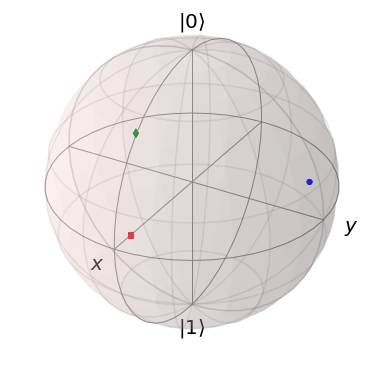

In [25]:
n = 3
n_qubit = n + 1
devs = [qml.device('default.qubit', wires=n_qubit)] * n
wires = [0, 1, 2, 3]

state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]
bloch_vecs = [state_2_bloch(state_vecs[i]) for i in range(n)]
bloch_vecs = [[0.8 * bloch_vecs[n][i] for i in range(3)] for n in range(n)]
a_priori_probs = [1/n] * n

# Visualization
bloch_sphere = qutip.Bloch()
for i in range(n):
    bloch_sphere.add_points(bloch_vecs[i])
bloch_sphere.show()

In [24]:
classifier = POVM_clf(3, wires, devs, a_priori_probs, bloch_vecs)

* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.39999999999999986, 0.6928203230275511, -1.2864981197413094e-16]
Output Bloch vector =  [-4.00409075e-01  6.92488730e-01  6.70355165e-05]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [0.8, 0.0, -1.2864981197413094e-16]
Output Bloch vector =  [8.01676473e-01 1.91851447e-04 7.56585232e-04]
* Optimizing for preparing a mixed state ..............................
Target Bloch vector =  [-0.39999999999999986, -0.6928203230275511, -1.2864981197413094e-16]
Output Bloch vector =  [-0.40031284 -0.69374326 -0.00358658]


In [26]:
steps=600
cost_list = classifier.run_opt(steps)

Cost(init_params)    :  0.6772293
Cost after step    20:  0.6674295
Cost after step    40:  0.6555607
Cost after step    60:  0.6261053
Cost after step    80:  0.5411453
Cost after step   100:  0.4576413
Cost after step   120:  0.4371585
Cost after step   140:  0.4330013
Cost after step   160:  0.4309848
Cost after step   180:  0.4286998
Cost after step   200:  0.4255742
Cost after step   220:  0.4214423
Cost after step   240:  0.4165301
Cost after step   260:  0.4115238
Cost after step   280:  0.4072586
Cost after step   300:  0.4041939
Cost after step   320:  0.4022642
Cost after step   340:  0.4011450
Cost after step   360:  0.4005198
Cost after step   380:  0.4001731
Cost after step   400:  0.3999791
Cost after step   420:  0.3998690
Cost after step   440:  0.3998056
Cost after step   460:  0.3997687
Cost after step   480:  0.3997471
Cost after step   500:  0.3997344
Cost after step   520:  0.3997268
Cost after step   540:  0.3997224
Cost after step   560:  0.3997197
Cost after ste

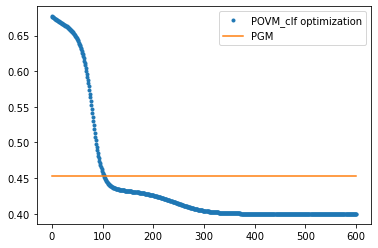

In [27]:
plt.plot(list(range(steps+1)), cost_list, '.', label='POVM_clf optimization')
pgm, cost_pgm = classifier.pgm()
plt.plot(list(range(steps+1)), [cost_pgm]*(steps+1), '-', label="PGM")
plt.legend()
plt.show()

In [28]:
rho = classifier.density_matrices
K = classifier.kraus_op()
E = classifier.povm()
med_povm = 1 - (1/n)*np.sum([np.real(np.trace(np.dot(rho[i],E[i]))) for i in range(n)], axis=0)
pgm, med_pgm = classifier.pgm()
print("=== Minimum-Error Discrimination ===")
print("by performing optimal POVM:", med_povm)
print("by performing PGM:", med_pgm)

classifier.res_table()

=== Minimum-Error Discrimination ===
by performing optimal POVM: 0.40000279392619775
by performing PGM: 0.45333333333333337


,rho_i,,E_i,,Tr[rho_i.E_i],PGM_i,,Tr[rho_i.PGM_i]
i=0,0.5000+0.0000j,-0.2000-0.3464j,0.3334+0.0000j,-0.1683-0.2873j,,0.3333-0.0000j,-0.1333-0.2309j,
,-0.2000+0.3464j,0.5000+0.0000j,-0.1683+0.2873j,0.3326+0.0000j,0.5994,-0.1333+0.2309j,0.3333-0.0000j,0.5467
i=1,0.5000+0.0000j,0.4000+0.0000j,0.3357+0.0000j,0.3350+0.0002j,,0.3333+0.0000j,0.2667+0.0000j,
,0.4000+0.0000j,0.5000+0.0000j,0.3350-0.0002j,0.3343+0.0000j,0.6030,0.2667+0.0000j,0.3333+0.0000j,0.5467
i=2,0.5000+0.0000j,-0.2000+0.3464j,0.3309+0.0000j,-0.1667+0.2871j,,0.3333+0.0000j,-0.1333+0.2309j,
,-0.2000-0.3464j,0.5000+0.0000j,-0.1667-0.2871j,0.3331+0.0000j,0.5976,-0.1333-0.2309j,0.3333+0.0000j,0.5467


---
Check Validity of Optimality Conditions

In [65]:
i, j = 0, 1
np.dot(np.dot(pgm[i], rho[i] - rho[j]), pgm[j])

tensor([[ 5.59737442e-18+5.80039465e-19j,
         -2.97500000e-02-1.71761705e-02j],
        [-2.97500000e-02+1.71761705e-02j,
          9.29811783e-18-2.16076401e-18j]], requires_grad=True)

In [72]:
i, j = 1, 2
np.dot(np.dot(E[i], rho[i] - rho[j]), E[j])

tensor([[-0.00043039-9.99921834e-06j,  0.00022485-3.68245770e-04j],
        [-0.00042896-9.23270331e-06j,  0.00022347-3.67389568e-04j]], requires_grad=True)